# Classificação de Imagens de 38 classes de plantas por tipos de doenças, com Transfer Learning
#### Objetivo: Analisar algumas redes com transfer learning e comparar os resultados, com base na variação de ajustes relacionados a parâmetros de early stop, early rate, camada dropout, camada BatchNormalize e Batchsize.
#### Após análises dos dados de cada uma das 38 classes de imagens e por questão de performance, na execução limitada de processamento, a opção foi por utilizar somente 04 classes de status das condições de folhas de Uva, sendo que uma delas não continha imangens, sendo assim essa descartada.


##### Classes Consideradas:
###### Grape___Black_rot
###### Grape___Esca_(Black_Measles)
###### Grape___healthy


## Legenda:
#### Localização da base de dados no Kaggle: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset
#### Base de dados de treino (trainpath): Já separada pelo autor da base de dados, em localização específica no Kaggle.
#### base de dados de validação (validpath): Já separada pelo autor da base de dados, em localização específica no Kaggle. 
## Consultas:
##### https://keras.io/applications/
##### https://keras.io/api/applications/vgg/
##### https://www.tensorflow.org/tutorials/load_data/images
##### https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory
##### https://keras.io/api/data_loading/

## Leitura do local da base de dados

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
workdir_path = '/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive' #MODIFICAR!!! #Caminho para o seu workspace
os.chdir(workdir_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.path.abspath(os.getcwd())

'/content/drive/MyDrive/TrabalhoFinal/DadosTCC/archive'

In [ ]:
# Base de imagens para treino com total de xx imagens (classes de tipos de platas)
trainpath = workdir_path + '/classeuva/Train'

# Base de imagens para validação com total de xx imagens (classes de tipos de platas)
validpath = workdir_path + '/classeuva/Valid'

# Base de imagens para testes com total de xx imagens (classes de tipos de platas)
testpath = workdir_path + '/classeuva/Test'

## Leitura de Bibliotecas

In [ ]:
!pip install keras_tqdm
import numpy as np
import keras as ks
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential, Model,load_model
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
import os
import tensorflow_datasets as tfds
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from PIL import Image
# from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.vgg16 import preprocess_input
from keras import losses
from tensorflow.keras.optimizers import RMSprop
from keras_tqdm import TQDMNotebookCallback
from random import randint
import matplotlib.pylab as plt




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Contagem das classes de treino

In [ ]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta
count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(trainpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [ ]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Contagem das classes de validação

In [ ]:
# Contar as imagens em cada pasta. Uma pasta = uma classe de planta
count=0
nomeplantas=[]
totalimagens=[]
for i in os.listdir(validpath):
  count+=1
  nomeplantas.append(i)
  
  images_path=os.listdir(trainpath+"/"+i)
  totalimagens.append(len(images_path))


In [ ]:
# Total de Classes de Plantas
len(nomeplantas)

3

## Tratar e  Carregar a Base de Treino
##### Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
##### A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imágens
batch_size = 32
# altura da imagem
img_height = 224
# largura da imagem
img_width = 224

In [ ]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

train_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de treino
  trainpath,                                                # caminho onde estão as imagens de treino (diretório "raiz")
  labels='inferred',                                       
  label_mode='categorical',                                            
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote


Found 4659 files belonging to 3 classes.


In [ ]:
# verifica o nome das classes (são 38 pastas, cada pasta é uma classe)
train_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [ ]:
# visualizar o tipo de objeto retornado
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 250 largura
# 250 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [ ]:
# Normalizar as imagens de treino para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
train_data_normalized = train_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(train_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.793597


In [ ]:
# Analisa o resultado da normalização da Base de Treino
for image_batch, labels_batch in train_data_normalized:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [ ]:
# Analisa o resultado da normalização da Base de Treino - Formato
train_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# Analisa o resultado da normalização da Base de Treino - Matriz EGB
image_batch[5]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.5795319 , 0.51286525, 0.48541418],
        [0.57541025, 0.5087436 , 0.48129255],
        [0.52094835, 0.45428175, 0.42683074],
        ...,
        [0.59491855, 0.55570287, 0.5164872 ],
        [0.56464547, 0.5254298 , 0.4862141 ],
        [0.53487366, 0.49565798, 0.4564423 ]],

       [[0.5026811 , 0.4360144 , 0.40856344],
        [0.5055022 , 0.43883556, 0.41138458],
        [0.5378752 , 0.47120848, 0.4437575 ],
        ...,
        [0.58079255, 0.54157686, 0.5023612 ],
        [0.5424967 , 0.503281  , 0.46406528],
        [0.5414368 , 0.5022211 , 0.46300545]],

       [[0.51034415, 0.4436775 , 0.4162265 ],
        [0.4811525 , 0.4144858 , 0.38703483],
        [0.4989396 , 0.43227294, 0.40482196],
        ...,
        [0.58601457, 0.5467989 , 0.50758314],
        [0.5528609 , 0.51364523, 0.4744295 ],
        [0.5608247 , 0.521609  , 0.48239332]],

       ...,

       [[0.5353126 , 0.5000185 , 0.48041064],
        [0.57

## Tratar e  Carregar a Base de Validação
## Ref: Como carregar imagens no Keras:
https://www.tensorflow.org/tutorials/load_data/images
## A documentação da função que usa para carregar os dados (detalhes dos parâmetros):
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [ ]:
# A carga da imagem é feita em lotes o tamanho de lote ("batch_size") de 32 imagens
batch_size = 32
# altura da imagem
img_height = 224
# largura da imagem
img_width = 224

In [ ]:
# usar a função para carregar as imagens:
# https://www.tensorflow.org/tutorials/load_data/images
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

valid_data = tf.keras.utils.image_dataset_from_directory(   # função para carregar imagens de validação
  validpath,                                                # caminho onde estão as imagens de vaçidção (diretório "raiz")
  labels='inferred',                                        
  label_mode='categorical',                                 
  image_size=(img_height, img_width),                       # largura e altura
  batch_size=batch_size)                                    # tamanho do lote

Found 1169 files belonging to 3 classes.


In [ ]:
# verifica o nome das classes (são 38 pastas, cada pasta é uma classe)
valid_data.class_names

['Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy']

In [ ]:
# visualizar o tipo de objeto retornado
valid_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# loop para ver a dimensão da imagem:
# 32 classes (pastas)
# 250 largura
# 250 altura
# 3 canais
# obs: Um break para evitar de percorrer todas as imagens
for image_batch, labels_batch in valid_data:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [ ]:
# Normalizar as imagens de validação para estabelecer uma variação de valores entre [0..1]. Camada específica para isso.
# Fonte: Documentação Keras

normalization_layer = tf.keras.layers.Rescaling(1./255)
valid_data_normalized = valid_data.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(valid_data_normalized))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.9335317


In [ ]:
# Analisa o resultado da normalização da Base de Validação
for image_batch, labels_batch in valid_data_normalized:
  print(image_batch.shape)
  break

(32, 224, 224, 3)


In [ ]:
# Analisa o resultado da normalização da Base de Validação - Formato
valid_data_normalized

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
# Analisa o resultado da normalização da Base de Validação - Matriz EGB
image_batch[2]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6927571 , 0.6456983 , 0.6613846 ],
        [0.68813527, 0.64107645, 0.6567627 ],
        [0.6786315 , 0.63157266, 0.64725894],
        ...,
        [0.67338955, 0.6302523 , 0.6537817 ],
        [0.67635053, 0.6332133 , 0.6567427 ],
        [0.6579429 , 0.61480564, 0.63833505]],

       [[0.67462987, 0.62757105, 0.6432573 ],
        [0.68121254, 0.6341537 , 0.64984   ],
        [0.6854742 , 0.6384154 , 0.65410167],
        ...,
        [0.6792919 , 0.63615465, 0.65968406],
        [0.6889957 , 0.64585847, 0.6693879 ],
        [0.68161255, 0.6384753 , 0.6620047 ]],

       [[0.6582633 , 0.6112045 , 0.6268908 ],
        [0.67254907, 0.62549025, 0.6411765 ],
        [0.68677473, 0.6397159 , 0.6554022 ],
        ...,
        [0.6724291 , 0.62929183, 0.65282124],
        [0.68597454, 0.6428373 , 0.6663667 ],
        [0.69269717, 0.6495599 , 0.6730893 ]],

       ...,

       [[0.57341   , 0.49497858, 0.49890015],
        [0.60

## Resumo Leitura de Imagens
##### 53655 .. 80% testes, 13414 .. 20% validação e 67.069 total de imagens

## Modelo de Classificação VGG16 sem Transfer Learning e Data Augmentation
##### Analisar a resposta da classificação

In [ ]:
pip install tf-explain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 6.3 MB/s eta 0:00:00


In [ ]:
## Código consultado em https://medium.com/analytics-vidhya/image-recognition-using-pre-trained-xception-model-in-5-steps-96ac858f4206

model = tf.keras.applications.VGG16(weights='imagenet', input_shape=(img_height,img_width,3))

# Carrega uma imagem de uma classe (Treino) para verificar a predição nessa Rede, nessas condições.
img = image.load_img(trainpath+"/Grape___healthy/ac753212-e6d7-44b9-9722-4413a7418ab3___Mt.N.V_HL 6178_180deg.JPG", target_size=(img_height,img_width,3))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=4)[0])


35363/35363 [==============================] - 0s 0us/step
Predicted: [('n03991062', 'pot', 0.71245605), ('n12768682', 'buckeye', 0.047697358), ('n07718472', 'cucumber', 0.0449126), ('n04522168', 'vase', 0.041108403)]


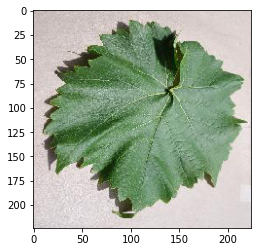

In [ ]:
# Avaliação da assertividade para a classe Tomato___Tomato_mosaic_virus da base de treino
import matplotlib.pylab as plt
plt.imshow(img)

Modelo nessa condição não obteve sucesso na identificação de uma imagem de uma classe. O que era previsto somente comprovando a necessidade de treinar um modelo aplicando Transfer Learning.

In [ ]:
# Visualização das Camadas do Modelo VGG16 sem Transfer Learning e Data Augmentation
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Analisa Camadas VGG16 Truncada

In [ ]:
base_model_tf=tf.keras.applications.VGG16(weights='imagenet', classes=3, input_shape=(img_height,img_width,3), include_top=False)

#Model building
base_model_tf.trainable=False

base_model_tf.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
## API Keras https://keras.io/guides/functional_api/
## https://keras.io/guides/sequential_model/

## Modelo VGG16 Base para Aplicar Transfer Learning


In [ ]:
# Modelo Truncado:
modelo_base = tf.keras.applications.VGG16(weights='imagenet', classes=3, input_shape=(img_height,img_width,3), include_top=False)
# "Congelar" as camadas superiores (manter os pesos):
modelo_base.trainable=False
modelo_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Modelo VGG16 Truncado + Camada Dense

*   Aproveitar a base de conhecimento Xception (Imagenet) e seus pesos
*   Treinar essa base adicionando as novas Classes de Treino das Imagens Coletadas



In [ ]:
# from tensorflow.keras.layers import Flatten
sh=Input(shape=(img_height,img_width,3)) # Formato de entrada imagem
conv=tf.cast(sh,tf.float32) 

modelo_dense_1=modelo_base(conv,training=False) #
modelo_dense_1=GlobalAveragePooling2D()(modelo_dense_1)
modelo_dense_1=Dropout(0.2)(modelo_dense_1)
modelo_dense_1=ks.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=0.001)(modelo_dense_1)
modelo_dense_1=Dense(128,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(64,activation='relu')(modelo_dense_1)
modelo_dense_1=Dense(3,activation='softmax')(modelo_dense_1)

from keras.models import Model
modelo_final_1=Model(inputs=sh,outputs=modelo_dense_1)
modelo_final_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                               

In [ ]:
modelo_final_1.layers

In [ ]:
# Definie as métricas
earlystp=EarlyStopping(patience=25, monitor='val_loss') # Evitar um Overfiting do Modelo
metrics = ['accuracy',Precision(),Recall(), AUC()]

In [ ]:
# Compila o Modelo
modelo_final_1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01),metrics=metrics)

In [ ]:
# Processa o modelo com Transfer Learning usando a base de imagens de Treino Normalizada e a base de Validação Normalizada
modelo_final_1_Hist = modelo_final_1.fit(train_data_normalized,validation_data=valid_data_normalized,epochs=200,verbose=1,callbacks=[earlystp])

Epoch 1/200
146/146 [==============================] - 1392s 10s/step - loss: 0.2804 - accuracy: 0.8785 - precision: 0.8859 - recall: 0.8736 - auc: 0.9777 - val_loss: 0.4734 - val_accuracy: 0.8657 - val_precision: 0.9612 - val_recall: 0.6997 - val_auc: 0.9774
Epoch 2/200
146/146 [==============================] - 26s 169ms/step - loss: 0.1841 - accuracy: 0.9227 - precision: 0.9230 - recall: 0.9210 - auc: 0.9893 - val_loss: 0.3156 - val_accuracy: 0.9281 - val_precision: 0.9508 - val_recall: 0.8922 - val_auc: 0.9889
Epoch 3/200
146/146 [==============================] - 30s 201ms/step - loss: 0.1759 - accuracy: 0.9305 - precision: 0.9318 - recall: 0.9298 - auc: 0.9906 - val_loss: 0.1679 - val_accuracy: 0.9384 - val_precision: 0.9423 - val_recall: 0.9358 - val_auc: 0.9949
Epoch 4/200
146/146 [==============================] - 25s 170ms/step - loss: 0.1582 - accuracy: 0.9337 - precision: 0.9344 - recall: 0.9324 - auc: 0.9922 - val_loss: 0.1409 - val_accuracy: 0.9564 - val_precision: 0.9625

## Análise da VGG16 - Transfer Learning
##### Métricas:
###### Acurácia: Taxa de acerto do modelo - VP + VN / (VP+VN+FN+FP). Pode mascarar falso positivo e falso negativo.
###### Recall: Taxa de VP entre todas as classes positivas. Varia de 0 a 1 , quanto maior o valor melhor - VP / VP + FN
###### Precisão: Taxa de VP entre os valores Positivos Preditos. VP / VP+FP. Quanto menor a qtd de falsos alarmes melhor.
###### AUC: Relação com a curva ROC (Receiver Operating Characteristic). É a área sob a curva e é recomendada para comparar modelos diferentes. Varia entre 0 e 1 e quanto maior o valor melhor a classificação.

In [ ]:
print(modelo_final_1_Hist.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


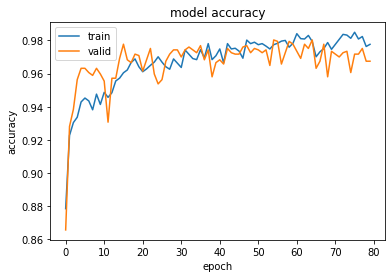

In [ ]:
plt.plot(modelo_final_1_Hist.history['accuracy'])
plt.plot(modelo_final_1_Hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

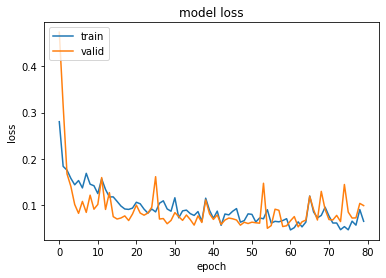

In [ ]:
plt.plot(modelo_final_1_Hist.history['loss'])
plt.plot(modelo_final_1_Hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

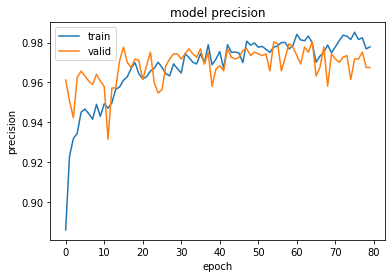

In [ ]:
plt.plot(modelo_final_1_Hist.history['precision'])
plt.plot(modelo_final_1_Hist.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

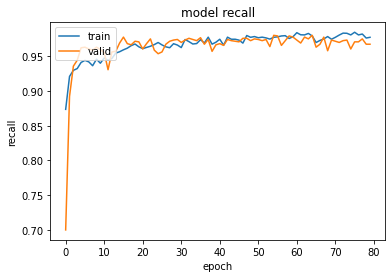

In [ ]:
plt.plot(modelo_final_1_Hist.history['recall'])
plt.plot(modelo_final_1_Hist.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

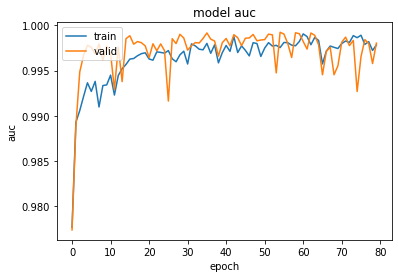

In [ ]:
plt.plot(modelo_final_1_Hist.history['auc'])
plt.plot(modelo_final_1_Hist.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()